## S-Mobile: Predicting Customer Churn

This specific case is the one where we are predicting customer churn from given data. It is to determine if existing data could be used to identify if some customers
were more likely to churn than others. And if so, what marketing actions and offers could be used to reduce churn.
The ultimate aim is to find the model would be used to generate churn predictions for 30,000 randomly chosen customers, i.e., the “representative sample” in the dataset, for whom we have have been authorized to evaluate the proactive churn management program.
Our objectives will be to find the optimal model and then understand the churn drivers and then suggest plans/offers to reduce churn rates for these customers.

**Note: Data is hidden for academic purposes**


In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import xgboost as xgb
from sklearn.inspection import permutation_importance, plot_partial_dependence
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# increase plot resolution
#mpl.rcParams["figure.dpi"] = 150

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = (s_mobile["churn"] == "yes").astype(int)

In [58]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


Use `smf.glm` with `freq_weights` and `cov_type` like in the below example
    
```python
lr = smf.glm(
    formula="churn_yes ~ changer + changem + ...",
    family=Binomial(link=logit()),
    data=pentathlon_nptb.query("training == 1"),
    freq_weights=s_mobile.loc[mobile.training == 1, "cweight"],
).fit(cov_type="HC1")
```

In [61]:
# importing functions from a module/package
#from utils import functions
#functions.example()

## Data Exploration

Show descriptive statistics in the training data

In [62]:
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,highcreditr,mcycle,car,travel,region,occupation,training,representative,churn_yes,cweight
0,U86940794,yes,109,81,62,600,141,0,0,8,...,no,no,no,no,CS,other,0.0,0,1,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,yes,no,no,no,SE,other,0.0,0,0,49
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,no,yes,no,yes,NW,professional,NaN,1,0,49
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,yes,no,no,NW,retired,1.0,0,0,49
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,no,yes,yes,no,SW,other,NaN,1,0,49


In [63]:
pd.get_dummies(
    s_mobile.loc[s_mobile.training == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.661245,28.956823,-62.0,305.0
changem,15.211392,51.885577,-78.0,521.0
revenue,57.211136,43.258950,0.0,856.0
mou,515.322308,525.458925,0.0,7668.0
overage,66.274286,69.258068,0.0,283.0
roam,1.197253,7.254327,0.0,692.0
conference,0.263480,1.083898,0.0,56.0
months,18.781502,9.595614,6.0,61.0
uniqsubs,1.546227,0.891051,1.0,18.0
custcare,2.288132,4.192970,0.0,32.0


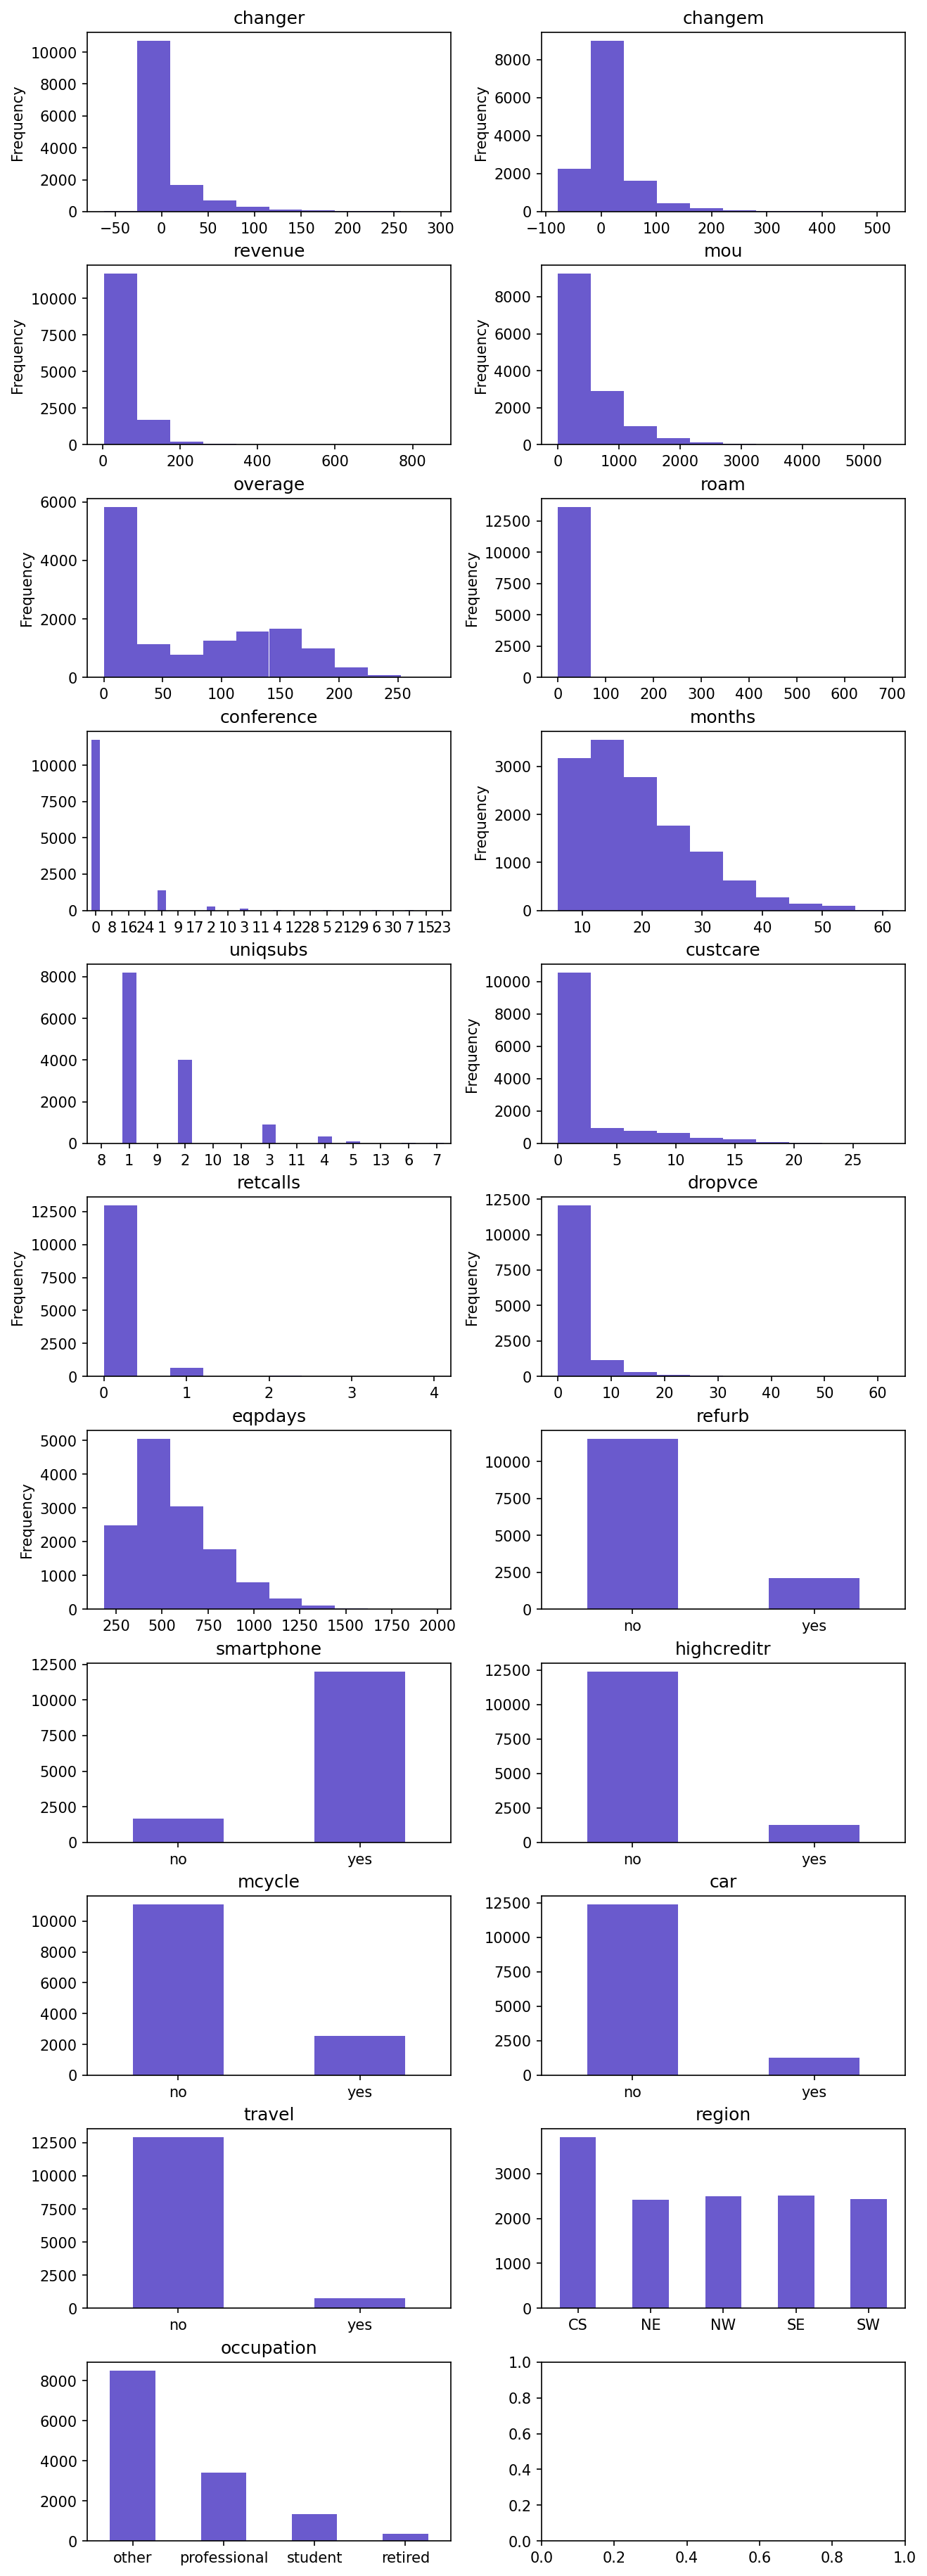

In [8]:
rsm.distr_plot(s_mobile.query('training == 1').query("churn == 'yes'").loc[:, "changer":"occupation"])

In [9]:
s_mobile.query('training == 1')[["changer", "changem", "revenue", "mou", "overage", "roam", "conference", "months", 
          "uniqsubs", "custcare", "retcalls", "dropvce", "eqpdays"]].corr(method ='pearson')

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,retcalls,dropvce,eqpdays
changer,1.000000,0.429952,0.122792,0.080259,0.230087,0.031774,0.038092,-0.042919,-0.000184,0.014933,0.007591,0.029431,-0.060510
changem,0.429952,1.000000,-0.008264,-0.055604,0.015811,-0.002999,-0.008377,-0.008140,-0.000857,-0.050818,-0.015216,-0.065884,-0.005403
revenue,0.122792,-0.008264,1.000000,0.703370,0.569594,0.269853,0.239194,-0.015845,-0.019772,0.238719,0.013510,0.447021,-0.216973
mou,0.080259,-0.055604,0.703370,1.000000,0.530462,0.123789,0.327108,-0.082009,-0.035518,0.465543,0.008666,0.613947,-0.311168
overage,0.230087,0.015811,0.569594,0.530462,1.000000,0.064414,0.161314,-0.034598,-0.019336,0.239410,0.016379,0.343032,-0.156801
roam,0.031774,-0.002999,0.269853,0.123789,0.064414,1.000000,0.037089,-0.016663,-0.008843,0.024431,-0.005705,0.090828,-0.031218
conference,0.038092,-0.008377,0.239194,0.327108,0.161314,0.037089,1.000000,-0.061844,-0.024388,0.221432,0.012184,0.303015,-0.110520
months,-0.042919,-0.008140,-0.015845,-0.082009,-0.034598,-0.016663,-0.061844,1.000000,0.007404,-0.135915,0.070440,-0.052701,0.476584
uniqsubs,-0.000184,-0.000857,-0.019772,-0.035518,-0.019336,-0.008843,-0.024388,0.007404,1.000000,-0.085620,-0.015944,-0.027440,-0.032492
custcare,0.014933,-0.050818,0.238719,0.465543,0.239410,0.024431,0.221432,-0.135915,-0.085620,1.000000,0.040952,0.364715,-0.231899


Show  descriptive statistics in the representative sample

In [10]:
pd.get_dummies(
   s_mobile.loc[s_mobile.representative == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.310567,28.496320,-90.0,437.0
changem,17.254533,51.375390,-78.0,540.0
revenue,56.634800,43.339533,0.0,1223.0
mou,540.767067,536.368824,0.0,7359.0
overage,61.723400,67.846131,0.0,265.0
roam,1.187867,10.058579,0.0,1112.0
conference,0.296400,1.284316,0.0,66.0
months,18.592767,9.928488,6.0,61.0
uniqsubs,1.501367,0.840013,1.0,12.0
custcare,2.514533,4.357846,0.0,32.0


In [14]:
# Defining weight
class_weight_dict = {0: 49, 1: 1}
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn == "yes", class_weight_dict[1], class_weight_dict[0])

In [15]:
training = s_mobile['training']
representative = s_mobile['representative']

In [16]:
# storing results for evaluation of different models
eval_dat = s_mobile.copy()
eval_dat["training"] = training
eval_dat = eval_dat[['customer', 'churn_yes', "training"]]

Estimating a Logistic Regression with weights (standardized). 

In [17]:
s_mobile['month_dummy'] = rsm.ifelse(s_mobile.months >= 12, "yes", "no")

In [18]:
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,mcycle,car,travel,region,occupation,training,representative,churn_yes,cweight,month_dummy
0,U86940794,yes,109,81,62,600,141,0,0,8,...,no,no,no,CS,other,0.0,0,1,1,no
1,U56788559,no,0,3,54,146,0,0,0,8,...,no,no,no,SE,other,0.0,0,0,49,no
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,yes,no,yes,NW,professional,NaN,1,0,49,no
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,no,no,NW,retired,1.0,0,0,49,yes
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,yes,no,SW,other,NaN,1,0,49,yes


In [19]:
Xs = rsm.scale_df(
    s_mobile.loc[:, "changer":"month_dummy"],
    train= s_mobile.training == 1,
    wt= s_mobile.cweight,
    excl=['training','representative','churn_yes', 'cweight'],
)
Xs["churn_yes"] = s_mobile.churn_yes
Xs

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,...,mcycle,car,travel,region,occupation,training,representative,churn_yes,cweight,month_dummy
0,1.795996,0.648059,0.059201,0.051482,0.583946,-0.090861,-0.126390,-0.534447,-0.299926,-0.285786,...,no,no,no,CS,other,0.0,0,1,1,no
1,-0.146109,-0.134122,-0.032648,-0.364217,-0.453367,-0.090861,-0.126390,-0.534447,0.275305,-0.285786,...,no,no,no,SE,other,0.0,0,0,49,no
2,-0.146109,-0.254458,-0.204864,0.562407,0.252889,-0.090861,0.310452,-0.483883,-0.299926,1.891054,...,yes,no,yes,NW,professional,NaN,1,0,49,no
3,-0.146109,-0.244430,-0.250789,0.014857,-0.453367,-0.090861,-0.126390,0.931900,-0.299926,-0.285786,...,yes,no,no,NW,retired,1.0,0,0,49,yes
4,-0.181744,-0.244430,0.495484,1.230822,0.370598,0.675463,-0.126390,0.072318,0.850537,-0.056645,...,yes,yes,no,SW,other,NaN,1,0,49,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68995,-0.146109,-0.314625,-0.273751,-0.453034,-0.453367,-0.090861,-0.126390,0.021754,-0.299926,-0.285786,...,yes,yes,no,SW,other,NaN,1,0,49,yes
68996,-0.146109,0.788450,-0.308194,-0.426480,-0.453367,-0.090861,-0.126390,-0.028810,0.275305,-0.285786,...,yes,yes,no,SE,other,1.0,0,0,49,yes
68997,-0.146109,-0.114066,-0.158940,-0.268991,-0.063455,-0.090861,-0.126390,0.325136,0.275305,-0.285786,...,no,no,no,CS,student,0.0,0,1,1,yes
68998,-0.199561,-0.455017,-0.181902,-0.234197,-0.453367,-0.090861,-0.126390,0.021754,-0.299926,-0.285786,...,no,no,no,CS,other,1.0,0,1,1,yes


In [20]:
idvar = "customer"
rvar = "churn_yes"
evar = [
    "changer", "changem", "mou",
    "overage", "roam", "months",
    "uniqsubs", "retcalls", 'dropvce', 
    'eqpdays', 'refurb', 'smartphone', 
    'highcreditr', 'mcycle', 
    'travel', 'region', 'occupation', 
    ]

In [21]:
form = "churn_yes ~ " + " + ".join(evar)
lr_3 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=Xs[s_mobile.training == 1],
).fit(cov_type="HC1")


In [95]:
table = (
    rsm.or_ci(lr_3, importance=True, data=s_mobile[s_mobile.training == 1])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)
table

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.186,-81.4%,0.168,0.207,< .001,***,True,5.369,0.137,0.344,0.0,1.0
1,highcreditr[T.yes],0.481,-51.9%,0.453,0.510,< .001,***,True,2.081,0.180,0.384,0.0,1.0
2,occupation[T.student],1.900,90.0%,1.788,2.018,< .001,***,True,1.900,0.055,0.227,0.0,1.0
3,eqpdays,1.831,83.1%,1.753,1.912,< .001,***,False,1.831,510.298,222.647,22.0,1982.0
4,overage,1.766,76.6%,1.693,1.842,< .001,***,False,1.766,61.625,67.964,0.0,283.0
5,region[T.SW],0.628,-37.2%,0.596,0.661,< .001,***,True,1.594,0.202,0.401,0.0,1.0
6,region[T.NE],0.645,-35.5%,0.612,0.679,< .001,***,True,1.551,0.199,0.399,0.0,1.0
7,mou,0.650,-35.0%,0.612,0.691,< .001,***,False,1.538,543.775,546.068,0.0,7668.0
8,region[T.SE],0.651,-34.9%,0.618,0.685,< .001,***,True,1.536,0.199,0.399,0.0,1.0
9,region[T.NW],0.661,-33.9%,0.628,0.696,< .001,***,True,1.513,0.199,0.399,0.0,1.0


In [ ]:
table.loc['index']

In [23]:
rsm.model_fit(lr_3)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Log-likelihood: -63798.616, AIC: 127643.232, BIC: 127906.203
Chi-squared: 690997.578 df(22), p.value < 0.001 
Nr obs: 27,300



In [24]:
lr_3.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,10452.125,0.000,1
refurb,121.740,0.000,1
smartphone,8.860,0.003,1
highcreditr,579.810,0.000,1
mcycle,31.339,0.000,1
travel,39.066,0.000,1
region,504.983,0.000,4
occupation,1703.082,0.000,3
changer,12.086,0.001,1
changem,40.187,0.000,1


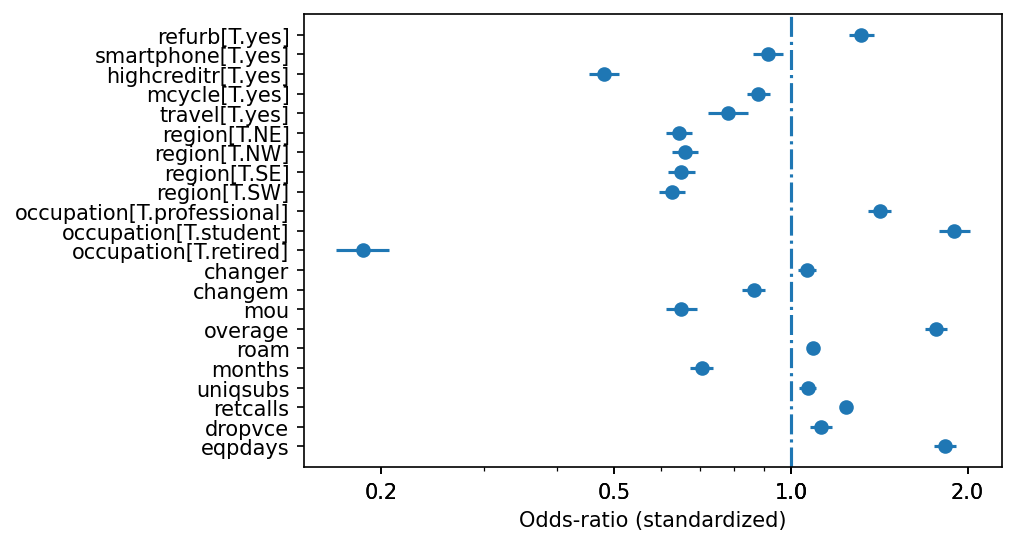

In [25]:
fig = rsm.or_plot(lr_3)
fig = fig.set_xlabel("Odds-ratio (standardized)")

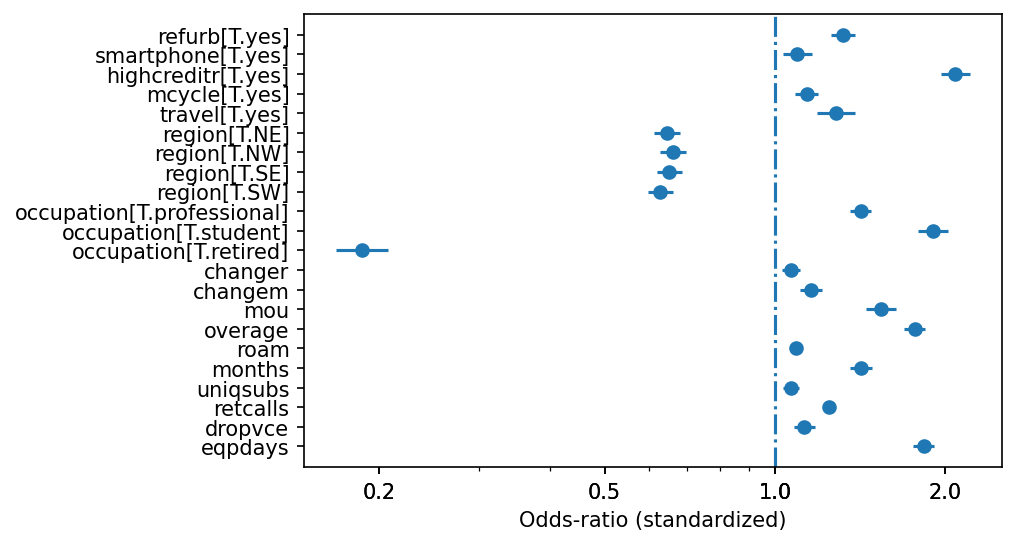

In [27]:
# flipping the OR plot

s_mobile_flipped = Xs.copy()
s_mobile_flipped["mou"] = -s_mobile_flipped.mou
s_mobile_flipped["changem"] = -s_mobile_flipped.changem
s_mobile_flipped["months"] = -s_mobile_flipped.months
s_mobile_flipped["highcreditr"] = rsm.ifelse(s_mobile_flipped.highcreditr == "yes", "no", "yes")
s_mobile_flipped["travel"] = rsm.ifelse(s_mobile_flipped.travel == "yes", "no", "yes")
s_mobile_flipped["mcycle"] = rsm.ifelse(s_mobile_flipped.mcycle == "yes", "no", "yes")
s_mobile_flipped["smartphone"] = rsm.ifelse(s_mobile_flipped.smartphone == "yes", "no", "yes")
lr33 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile_flipped[s_mobile.training == 1],
).fit(cov_type="HC1")
# lr.summary()
fig = rsm.or_plot(lr33)
fig = fig.set_xlabel("Odds-ratio (standardized)")

In [92]:
eval_dat["y_lr3"] = lr_3.predict(s_mobile)
s_mobile["y_pred"] = lr_3.predict(s_mobile)

/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


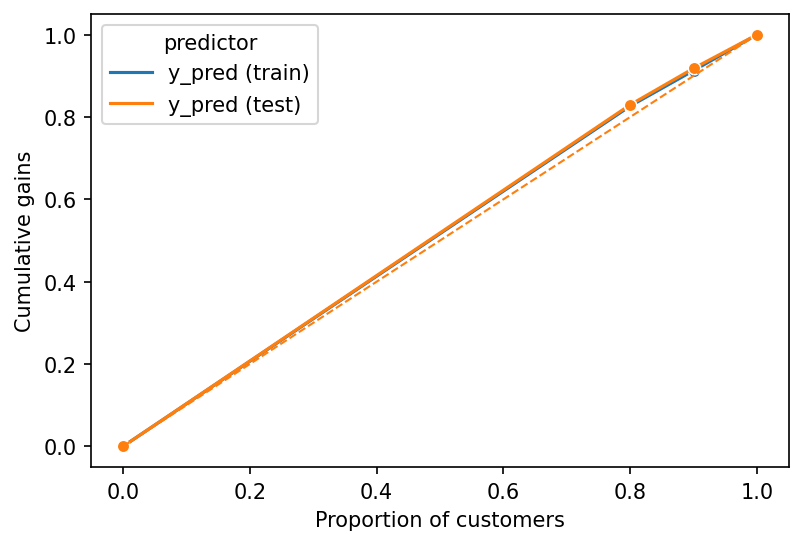

In [93]:
# check if model has overfitting issue
dct = {"train": s_mobile.query("training == 1"), "test": s_mobile.query("training == 0")}
fig = rsm.gains_plot(dct, "churn_yes", 1, "y_pred")

Looking at the table above and trying to figure out the best variables in this business context, the following are the important drivers:
<br>As can be see from the table, being retired has the highest impact on the churn rate. As can we seen, being retired will decrease the odds of churning by 81% compared to base category(others) keep the other variable constant.
<br>As can we seen, having high credit rate will decrease the odds of churning by 52% compared to base category(those customers with medium or low credit rate) keep the other variable constant

### Quantify the impact of actions/offers/incentives on the probability of churn

We are defining two new variables here, over rage dummy which will be yes for those customer with the monthly over rage usage above the mean(66.27 minutes)
<br>The next one is revenue dummy which will be yes for those customers who are generating monthly revenue for the company above the mean( 58$)

In [30]:
s_mobile.query("training==1")["revenue"].describe()

count    27300.000000
mean        57.211136
std         43.258950
min          0.000000
25%         32.000000
50%         47.000000
75%         69.000000
max        856.000000
Name: revenue, dtype: float64

In [31]:
s_mobile['revenue_dummy'] = rsm.ifelse(s_mobile.revenue >= 57.211136, "yes", "no")

#### Action 1: 
We can start by calculating churn numbers for those customers that experienced over_rage in the representative sample. 
This will require us to use the logistic regression model estimated above (assigned to `lr_3`) to generate predictions as if we eliminated 
<br>all over rage by setting the values in the delay column to 0. 
<br>In the table  we can see that the actually churn rate among those that experienced over rage was 2.43%. 
<br>Our logistic regression model predicts that removing over rage for these customers would reduce churn to 1.8% on average.

In [32]:
# impact of eliminating overage on churn probability
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_overage0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(overage=0))
s_mobile_rep.loc[s_mobile_rep.overage > 0, ["churn_yes", "p_overage0"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_overage0
count,16264.0000,16264.000
mean,0.0243,0.018


In [33]:
print("Number of customers with high churn rates and usage above limit:", len(s_mobile_rep.query("p_overage0 > 0.02 & overage > 0")))
print("Percentage of customers with high churn rates and usage above limit:", 
      (len(s_mobile_rep.query("p_overage0 > 0.02 & overage > 0")) / len(s_mobile_rep)))

Number of customers with high churn rates and usage above limit: 5927
Percentage of customers with high churn rates and usage above limit: 0.19756666666666667


In [34]:
print("Number of high revenue generating customers with high churn rates and usage above limit :", len(s_mobile_rep.query("p_overage0 > 0.02 & overage > 0 & revenue_dummy == 'yes'")))
print("Percentage of high revenue generating customers with high churn rates and usage above limit:", 
      (len(s_mobile_rep.query("p_overage0 > 0.02 & overage > 0 & revenue_dummy == 'yes'")) / len(s_mobile_rep)))

Number of high revenue generating customers with high churn rates and usage above limit : 2183
Percentage of high revenue generating customers with high churn rates and usage above limit: 0.07276666666666666


As we mentioned before, the overage has a significant impact on the churn rate of the customer. A possible action regarding this problem could be increasing the usage limit for the customers. 

It should be mentioned that, for reducing the cost of providing unlimited call/ data to the risky customers, we could target those high risk customer who are generating high revenue for the company. By considering this specific group, we should target only 2,183 customers which is around 7.3% of the population

#### Action 2
As can be seen from the following table, the churn rate for those customers who are using their phone more than 365 days is equal to 2.31%
offering a new phone to the customer will reduce the churn rate to 1.92%

In [35]:
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_eqpdays0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(eqpdays = 0))
s_mobile_rep.loc[s_mobile_rep.eqpdays > 365, ["churn_yes", "p_eqpdays0"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_eqpdays0
count,21881.0000,21881.0000
mean,0.0231,0.0192


In [36]:
print("Number of high risk customer with a phone older than 1 year:", 
      len(s_mobile_rep.query("p_eqpdays0 > 0.02  & eqpdays > 365")))
print("Percentage of high risk customer with a phone older than 1 year:", 
      (len(s_mobile_rep.query("p_eqpdays0 > 0.02 & eqpdays > 365")) / len(s_mobile_rep)))

Number of high risk customer with a phone older than 1 year: 8986
Percentage of high risk customer with a phone older than 1 year: 0.2995333333333333


### Action 3

We can see that the churn rate for those customers who has the services less than a year is 1.71%. If we require that all the customers sign a contract for at least a year, the churn rate will reduce significantly( almost zero)

In [37]:
s_mobile_rep["p_month0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(months = 12))
s_mobile_rep.loc[s_mobile_rep.months < 12, ["churn_yes", "p_month0"]].agg(
    ["count", "mean"]
).round(5)

,churn_yes,p_month0
count,8870.00000,8870.00000
mean,0.01714,0.00024


They can substitute monthly plans with yearly plans with the option of getting a new phone on renewal and hence reduce churn rates.

### Action 4

As can be seen from the following table, the churn rate for those customers who are using their phone more than 365*1.5 days (18 months) is equal to 2.51% offering a new phone to the customer will reduce the churn rate to 1.78%

In [38]:
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_eqpdays0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(eqpdays = 0))
s_mobile_rep.loc[s_mobile_rep.eqpdays > 365*1.5, ["churn_yes", "p_eqpdays0"]].agg(
    ["count", "mean"]
).round(5)

,churn_yes,p_eqpdays0
count,10270.00000,10270.0000
mean,0.02512,0.0178


In [39]:
print("Number of high risk customer with a phone older than 1.5 years:", 
      len(s_mobile_rep.query("p_eqpdays0 > 0.02  & eqpdays > 365 * 1.5")))
print("Percentage of high risk customer with a phone older than 1.5 years:", 
      (len(s_mobile_rep.query("p_eqpdays0 > 0.02 & eqpdays > 365 * 1.5")) / len(s_mobile_rep)))

Number of high risk customer with a phone older than 1.5 years: 3753
Percentage of high risk customer with a phone older than 1.5 years: 0.1251


### Action 5

Similar to the action 2, the churn rate for those customers who has the services less than 18 months is 2%. If we require that all the customers sign a contract for at least 18 months, the churn rate will reduce significantly( almost zero). Proposal similar to action 3 can be applied here. (encouraging customers to sign a long term contract with the option of getting new phones)

In [40]:
s_mobile_rep["p_month0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(months = 18))
s_mobile_rep.loc[s_mobile_rep.months < 18, ["churn_yes", "p_month0"]].agg(
    ["count", "mean"]
).round(5)

,churn_yes,p_month0
count,16253.00000,16253.00000
mean,0.02006,0.00004


### Action 6

As can be seen from the following table, the churn rate for those customers who are using their phone more than 365*2 days (24 months) is equal to 2.42% offering a new phone to the customer will reduce the churn rate to 1.67%

In [41]:
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_eqpdays0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(eqpdays = 0))
s_mobile_rep.loc[s_mobile_rep.eqpdays > 365*2, ["churn_yes", "p_eqpdays0"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_eqpdays0
count,4872.0000,4872.0000
mean,0.0242,0.0167


In [42]:
print("Number of high risk customer with a phone older than 2 years:", 
      len(s_mobile_rep.query("p_eqpdays0 > 0.02  & eqpdays > 365*2")))
print("Percentage of high risk customer with a phone older than 2 years:", 
      (len(s_mobile_rep.query("p_eqpdays0 > 0.02 & eqpdays > 365*2")) / len(s_mobile_rep)))

Number of high risk customer with a phone older than 2 years: 1585
Percentage of high risk customer with a phone older than 2 years: 0.052833333333333336


### Action 7

The churn rate for those customers who has the services less than 2 years is 2.05%. If we require that all the customers sign a contract for at least 24 months, the churn rate will reduce significantly(almost zero). Proposal similar to action 3 can be applied here.(encouraging customers to sign a long term contract with the option of getting new phones)

In [43]:
s_mobile_rep["p_month0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(months = 24))
s_mobile_rep.loc[s_mobile_rep.months < 24, ["churn_yes", "p_month0"]].agg(
    ["count", "mean"]
).round(5)

,churn_yes,p_month0
count,21925.00000,21925.0
mean,0.02048,0.0


It should be mentioned that in the following section we are proposing different policies regarding the phone renewal.

#### Action 8
As can be seen from the following table, if all the customers have had a high credit rating, their churn rate would decrease to 1.07%.
<br>It can be argued that targeting customers with higher credit scores will be beneficial for the company since this specific group of customer has the lower churn rate

In [44]:
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_highcreditr0"] = lr_3.predict(Xs[s_mobile.representative == 1].assign(highcreditr = 'yes'))
s_mobile_rep.loc[s_mobile_rep.highcreditr == 'no', ["churn_yes", "p_highcreditr0"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_highcreditr0
count,24487.0000,24487.0000
mean,0.0223,0.0107


In [45]:
print("Number of high risk customer with good credit rate:", 
      len(s_mobile_rep.query("p_highcreditr0 > 0.02  & highcreditr == 'yes'")))
print("Percentage of high risk customer with good credit rate:", 
      (len(s_mobile_rep.query("p_highcreditr0 > 0.02 & highcreditr == 'yes'")) / len(s_mobile_rep)))

Number of high risk customer with good credit rate: 360
Percentage of high risk customer with good credit rate: 0.012


In [46]:
print("Number of high risk customer with good credit rate and high income generation:", 
      len(s_mobile_rep.query("p_highcreditr0 > 0.02  & highcreditr == 'yes' & revenue_dummy == 'yes'")))
print("Percentage of high risk customer with good credit rate and high income generation:", 
      (len(s_mobile_rep.query("p_highcreditr0 > 0.02 & highcreditr == 'yes' & revenue_dummy == 'yes'")) / len(s_mobile_rep)))

Number of high risk customer with good credit rate and high income generation: 188
Percentage of high risk customer with good credit rate and high income generation: 0.006266666666666667


In [47]:
print("Number of high risk customer with medium or low credit rate:", 
      len(s_mobile_rep.query("p_highcreditr0 > 0.02  & highcreditr == 'no'")))
print("Percentage of high risk customer with medium or low credit rate:", 
      (len(s_mobile_rep.query("p_highcreditr0 > 0.02 & highcreditr == 'no'")) / len(s_mobile_rep)))

Number of high risk customer with medium or low credit rate: 2053
Percentage of high risk customer with medium or low credit rate: 0.06843333333333333


For people with low credit rate and higher churn risk, we can target them using a different approach which is more suitable: like 2 month free subscription, family plan benefits, conference call benefits, etc.

## Economic Justification of actions using CLV metric

In [48]:
# We are assuming costs here to be 40% overall.
cost_service = 0.2
cost_marketing = 0.2

# We are assuming the annual discount rate here to be 10%.
annual_discount = 0.1
month_discount = (1+annual_discount)**(1/12)-1

revenue = s_mobile_rep.revenue.mean()

In [49]:
def CLV_calc(monthly_revenue, churn):
    df = pd.DataFrame({"revenue": [revenue]*60})
    df['profit'] = df['revenue'] * (1 - cost_service - cost_marketing)
    df['discount #'] = range(1,61) 
    df['retention rate'] = None
    df['churn rate'] = churn
    for i in range(60):
        if i == 0:
            df.loc[i, 'retention rate'] = 1 
        else:
            df.loc[i, 'retention rate'] = df.loc[i-1, 'retention rate'] * (1-df.loc[i-1, 'churn rate'])
    df['expected profit'] = df['retention rate'] * df['profit'] 
    df['present value'] = df['expected profit'] / (1 + month_discount) ** df['discount #'] 
    df['clv'] = None
    for i in range(60):
        if i == 0:
            df.loc[i, 'clv'] = df.loc[i, 'present value']
        else:
            df.loc[i, 'clv'] = df.loc[i, 'present value'] + df.loc[(i-1), 'clv']
    return df['clv']

In [124]:
def profit_diff(condition, churn_base, churn_new, percent):
    reps = s_mobile.query('representative == 1').query(condition)
    clv_base = CLV_calc(reps['revenue'].mean(), churn_base)
    clv_new = CLV_calc(reps['revenue'].mean(), churn_new)
    clv_diff = clv_new - clv_base
    perc = len(reps['churn'])/30000 * percent
    profit_change = 1000000 * perc * clv_diff
    result = pd.DataFrame({'clv base': clv_base, 'clv new': clv_new, 'clv diff': clv_diff, 'accumulative scaled_profit': profit_change})
    return result

In [125]:
### Action 1: 

In [126]:
clv_overage = profit_diff('overage > 0', 0.0243, 0.018, 1)
clv_overage.index = range(1,61)
clv_overage

,clv base,clv new,clv diff,accumulative scaled_profit
1,33.712055,33.712055,0.0,0.0
2,66.344691,66.555396,0.210706,114230.611343
3,97.932467,98.552408,0.619941,336090.735384
4,128.508841,129.7249,1.21606,659266.484688
5,158.106195,160.094119,1.987924,1077720.032268
6,186.755877,189.680764,2.924887,1585678.868219
7,214.48823,218.505001,4.016771,2177625.449421
8,241.332626,246.586476,5.25385,2848287.228441
9,267.317495,273.944328,6.626833,3592627.04828
10,292.470361,300.597206,8.126846,4405833.890035


Text(0.5, 0, 'months')

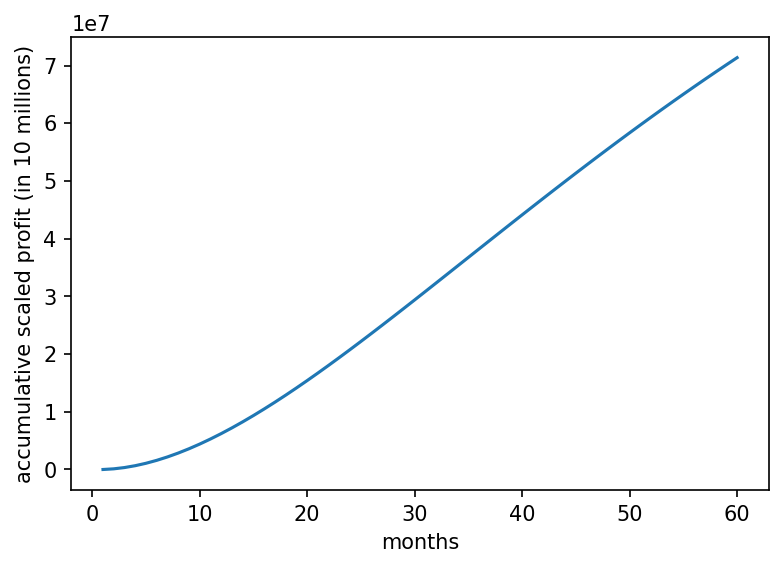

In [131]:
clv_overage = clv_overage.astype(float)
plt.figure()
profit = sns.lineplot(x= clv_overage.index, y = 'accumulative scaled_profit', data = clv_overage)
plt.ylabel('accumulative scaled profit (in 10 millions)')
plt.xlabel('months')

Text(0, 0.5, 'clv')

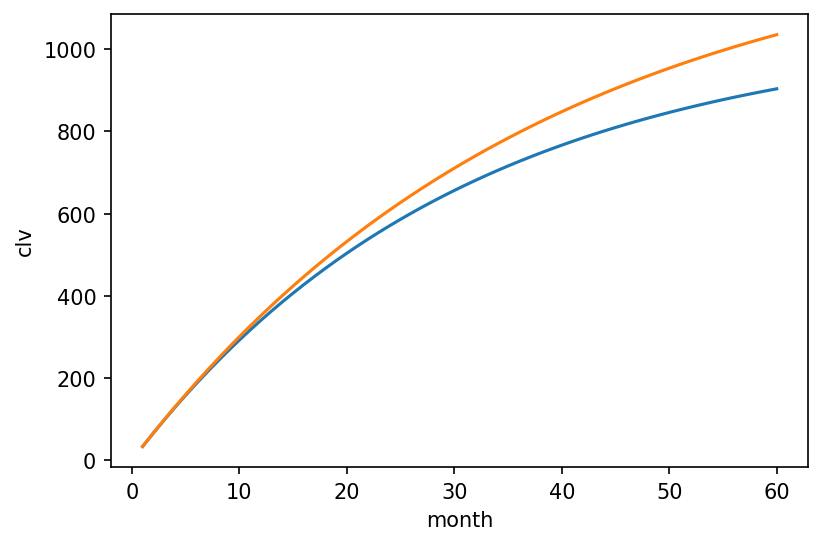

In [138]:
plt.figure()
base = sns.lineplot(x= clv_overage.index, y = 'clv base', data = clv_overage)
new = sns.lineplot(x= clv_overage.index, y = 'clv new', data = clv_overage)
plt.xlabel('month')
plt.ylabel('clv')

Considering the first proposal(unlimited call/data) , at the end of the fifth year, we are creating additional 71,360,677.4$ in profit

In [132]:
clv_eqpdays = profit_diff('eqpdays > 365', 0.0231,0.0192, 1)
clv_eqpdays.index = range(1,61)
clv_eqpdays

,clv base,clv new,clv diff,accumulative scaled_profit
1,33.712055,33.712055,0.0,0.0
2,66.384825,66.515262,0.130437,95136.322372
3,98.050348,98.434121,0.383773,279911.279226
4,128.739677,129.492475,0.752798,549065.811855
5,158.482905,159.713521,1.230616,897570.270115
6,187.3092,189.119834,1.810633,1320615.526314
7,215.246829,217.733376,2.486547,1813604.411953
8,242.323189,245.575522,3.252333,2372143.466022
9,268.564829,272.667066,4.102237,2992034.983999
10,293.997484,299.028245,5.030761,3669269.357003


Text(0.5, 0, 'months')

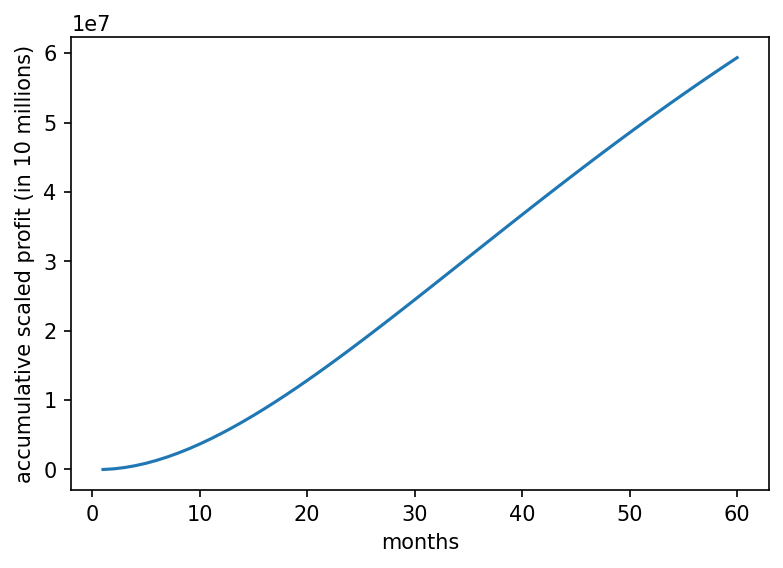

In [133]:
clv_eqpdays = clv_eqpdays.astype(float)
plt.figure()
profit = sns.lineplot(x= clv_eqpdays.index, y = 'accumulative scaled_profit', data = clv_eqpdays)
plt.ylabel('accumulative scaled profit (in 10 millions)')
plt.xlabel('months')

Text(0, 0.5, 'clv')

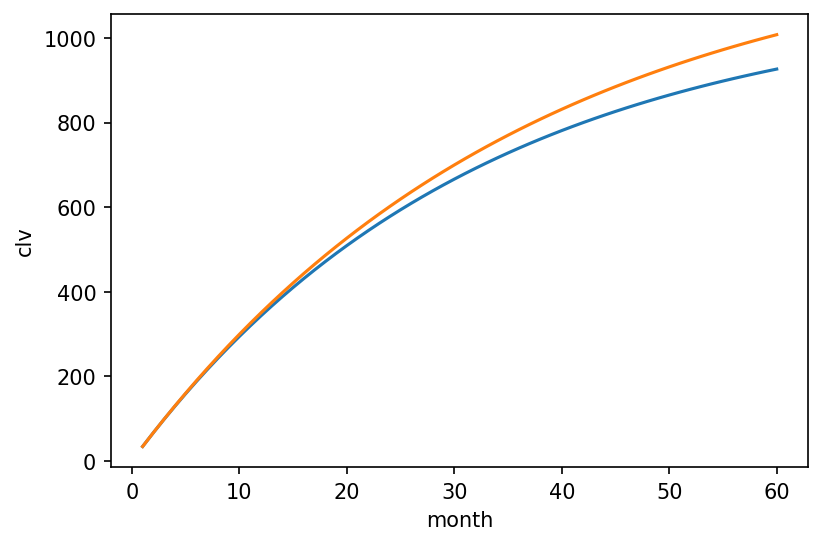

In [139]:
plt.figure()
base = sns.lineplot(x= clv_eqpdays.index, y = 'clv base', data = clv_eqpdays)
new = sns.lineplot(x=clv_eqpdays.index, y = 'clv new', data = clv_eqpdays)
plt.xlabel('month')
plt.ylabel('clv')

Considering the second proposal( giving the option of changing the old phone with a new one), at the end of the fifth year, we are creating additional 59,353,789.2$ in profit

## Appendix
### Other Models

Estimating a Logistic Regression with weights (unstandardized)

In [58]:
idvar = "customer"
rvar = "churn_yes"
evar = [
    "changer", "changem",
    "revenue", "mou",
    "overage", "roam",
    "conference", "months",
    "uniqsubs", "custcare",
    "retcalls", 'dropvce', 
    'eqpdays', 'refurb', 
    'smartphone', 'highcreditr', 
    'mcycle', 'car', 
    'travel', 'region', 'occupation'
    
]

In [59]:
form = "churn_yes ~ " + " + ".join(evar)
lr_mod_1 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile[s_mobile.training == 1],
)
lr_1 = lr_mod_1.fit(cov_type="HC1")
rsm.or_ci(lr_1)

,index,OR,OR%,2.5%,97.5%,p.values,
1,refurb[T.yes],1.318,31.8%,1.255,1.385,< .001,***
2,smartphone[T.yes],0.913,-8.7%,0.860,0.969,0.003,**
3,highcreditr[T.yes],0.483,-51.7%,0.455,0.513,< .001,***
4,mcycle[T.yes],0.883,-11.7%,0.834,0.934,< .001,***
5,car[T.yes],0.991,-0.9%,0.919,1.068,0.809,
6,travel[T.yes],0.781,-21.9%,0.723,0.844,< .001,***
7,region[T.NE],0.644,-35.6%,0.611,0.678,< .001,***
8,region[T.NW],0.660,-34.0%,0.627,0.695,< .001,***
9,region[T.SE],0.651,-34.9%,0.618,0.685,< .001,***
10,region[T.SW],0.627,-37.3%,0.595,0.660,< .001,***


In [60]:
rsm.model_fit(lr_1)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Log-likelihood: -63795.467, AIC: 127644.935, BIC: 127953.64
Chi-squared: 691107.451 df(26), p.value < 0.001 
Nr obs: 27,300



In [61]:
lr_1.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,5762.140,0.000,1
refurb,121.728,0.000,1
smartphone,8.950,0.003,1
highcreditr,559.722,0.000,1
mcycle,18.519,0.000,1
car,0.058,0.809,1
travel,38.734,0.000,1
region,506.107,0.000,4
occupation,1693.227,0.000,3
changer,11.976,0.001,1


car, revenue, conference, custcare - p-value > 0.05

In [62]:
eval_dat["y_lr1"] = lr_1.predict(s_mobile)

In [63]:
form = "churn_yes ~ " + " + ".join(evar)
lr_mod_2 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile[s_mobile.training == 1],
)
lr_2 = lr_mod_2.fit(cov_type="HC1")

In [64]:
(
    rsm.or_ci(lr_2, importance=True, data=s_mobile[s_mobile.training == 1])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.184,-81.6%,0.166,0.205,< .001,***,True,5.422,0.137,0.344,0.0,1.0
1,highcreditr[T.yes],0.483,-51.7%,0.455,0.513,< .001,***,True,2.069,0.180,0.384,0.0,1.0
2,occupation[T.student],1.900,90.0%,1.788,2.018,< .001,***,True,1.900,0.055,0.227,0.0,1.0
3,retcalls,1.805,80.5%,1.695,1.923,< .001,***,False,1.805,0.029,0.185,0.0,4.0
4,region[T.SW],0.627,-37.3%,0.595,0.660,< .001,***,True,1.595,0.202,0.401,0.0,1.0
5,region[T.NE],0.644,-35.6%,0.611,0.678,< .001,***,True,1.553,0.199,0.399,0.0,1.0
6,region[T.SE],0.651,-34.9%,0.618,0.685,< .001,***,True,1.537,0.199,0.399,0.0,1.0
7,region[T.NW],0.660,-34.0%,0.627,0.695,< .001,***,True,1.516,0.199,0.399,0.0,1.0
8,occupation[T.professional],1.416,41.6%,1.355,1.479,< .001,***,True,1.416,0.174,0.379,0.0,1.0
9,refurb[T.yes],1.318,31.8%,1.255,1.385,< .001,***,True,1.318,0.134,0.341,0.0,1.0


In [65]:
rsm.model_fit(lr_2)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Log-likelihood: -63795.467, AIC: 127644.935, BIC: 127953.64
Chi-squared: 691107.451 df(26), p.value < 0.001 
Nr obs: 27,300



In [66]:
lr_2.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,5762.140,0.000,1
refurb,121.728,0.000,1
smartphone,8.950,0.003,1
highcreditr,559.722,0.000,1
mcycle,18.519,0.000,1
car,0.058,0.809,1
travel,38.734,0.000,1
region,506.107,0.000,4
occupation,1693.227,0.000,3
changer,11.976,0.001,1


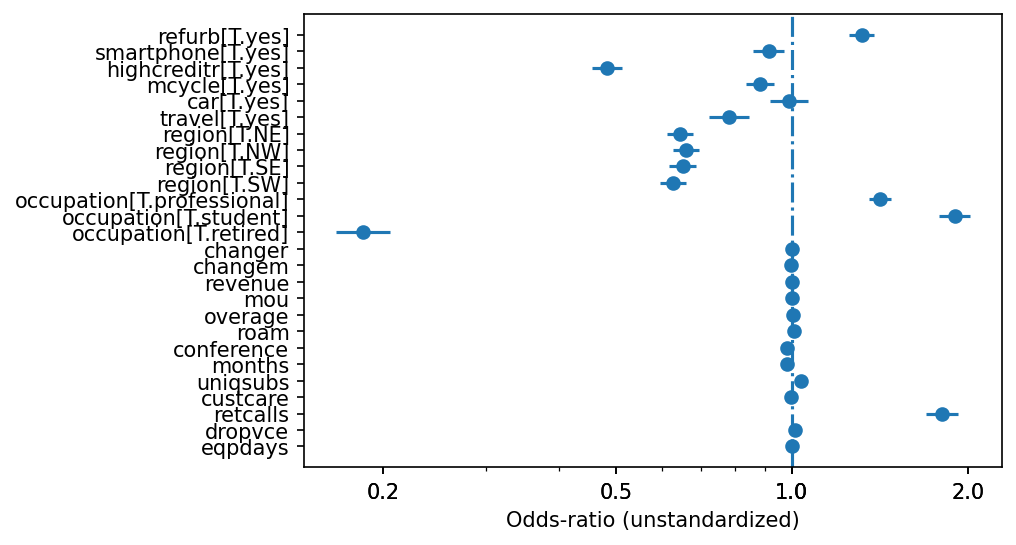

In [67]:
fig = rsm.or_plot(lr_2)
fig = fig.set_xlabel("Odds-ratio (unstandardized)")

In [68]:
eval_dat["y_lr2"] = lr_2.predict(s_mobile)

In [70]:
lr_mod = smf.glm(
    formula="""churn_yes ~  changer +changem
    +overage  + uniqsubs + retcalls 
    +eqpdays + refurb + smartphone + highcreditr + mcycle
    +travel + region + occupation 
    + eqpdays:changer  + eqpdays:mou 
    + eqpdays:roam + eqpdays:months + eqpdays:uniqsubs + eqpdays:retcalls
    + eqpdays:dropvce + eqpdays:refurb +  eqpdays:highcreditr 
    + eqpdays:travel  + eqpdays:occupation + months:retcalls  
    + overage:changer  + overage:retcalls  
    + overage:occupation 
    + occupation:changer + occupation:changem + occupation:uniqsubs
    + occupation:travel + occupation:region 
    + mou:refurb + mou:region + mou:occupation
    + changem:changer""",
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile[s_mobile.training == 1],
)
lr = lr_mod.fit(cov_type="HC1")

In [71]:
eval_dat["y_lri"] = lr.predict(s_mobile)

In [72]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.052
Pseudo R-squared (McFadden adjusted): 0.051
Log-likelihood: -63448.674, AIC: 127041.348, BIC: 127864.561
Chi-squared: 685562.774 df(71), p.value < 0.001 
Nr obs: 27,300



In [73]:
lr.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,3679.216,0.000,1
refurb,69.563,0.000,1
smartphone,12.602,0.000,1
highcreditr,46.573,0.000,1
mcycle,33.252,0.000,1
travel,4.595,0.032,1
region,139.456,0.000,4
occupation,176.032,0.000,3
occupation:travel,37.592,0.000,3
occupation:region,28.448,0.005,12


### XGBOOST

In [74]:
X = pd.get_dummies(s_mobile[[ "changer", "changem","mou",
    "overage", "roam", "months",
    "uniqsubs", "retcalls", 'dropvce', 
    'eqpdays', 'refurb', 'smartphone', 
    'highcreditr', 'mcycle',  'travel', 'region', 'occupation']], drop_first=True)
y = s_mobile.churn_yes

In [87]:
# XGBoost with cross-validation and grid search
clf = xgb.XGBClassifier(objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight= 1 / 49,
    eval_metric="auc",
    random_state=1234)
param_grid = {
    "max_depth": list(range(1, 5)),
    "n_estimators": list(range(100, 301, 100)),
}
scoring = {"AUC": "roc_auc"}

gbm_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X[s_mobile.training == 1], y[s_mobile.training == 1])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [88]:
gbm_cv.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [76]:
clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=200,
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight=1 / 49,
    eval_metric="auc",
    random_state=1234,
).fit(X[s_mobile.training == 1], y[s_mobile.training == 1], verbose=True)

In [77]:
eval_dat["y_xgb"] = clf.predict_proba(X)[:, 1]

Check that the predicted probabilities in the representative dataset are scaled appropriately

In [78]:
clf.predict_proba(X[s_mobile.representative == 1])[:, 1].mean().round(3)

0.022

In [79]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

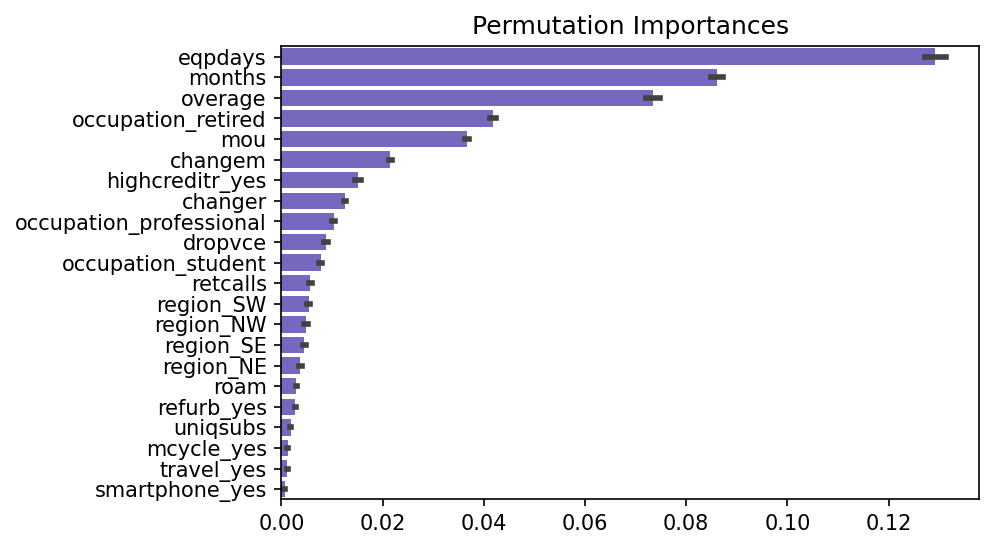

In [80]:
fig = importance(clf, X[s_mobile.training == 1], y[s_mobile.training == 1], X.columns)

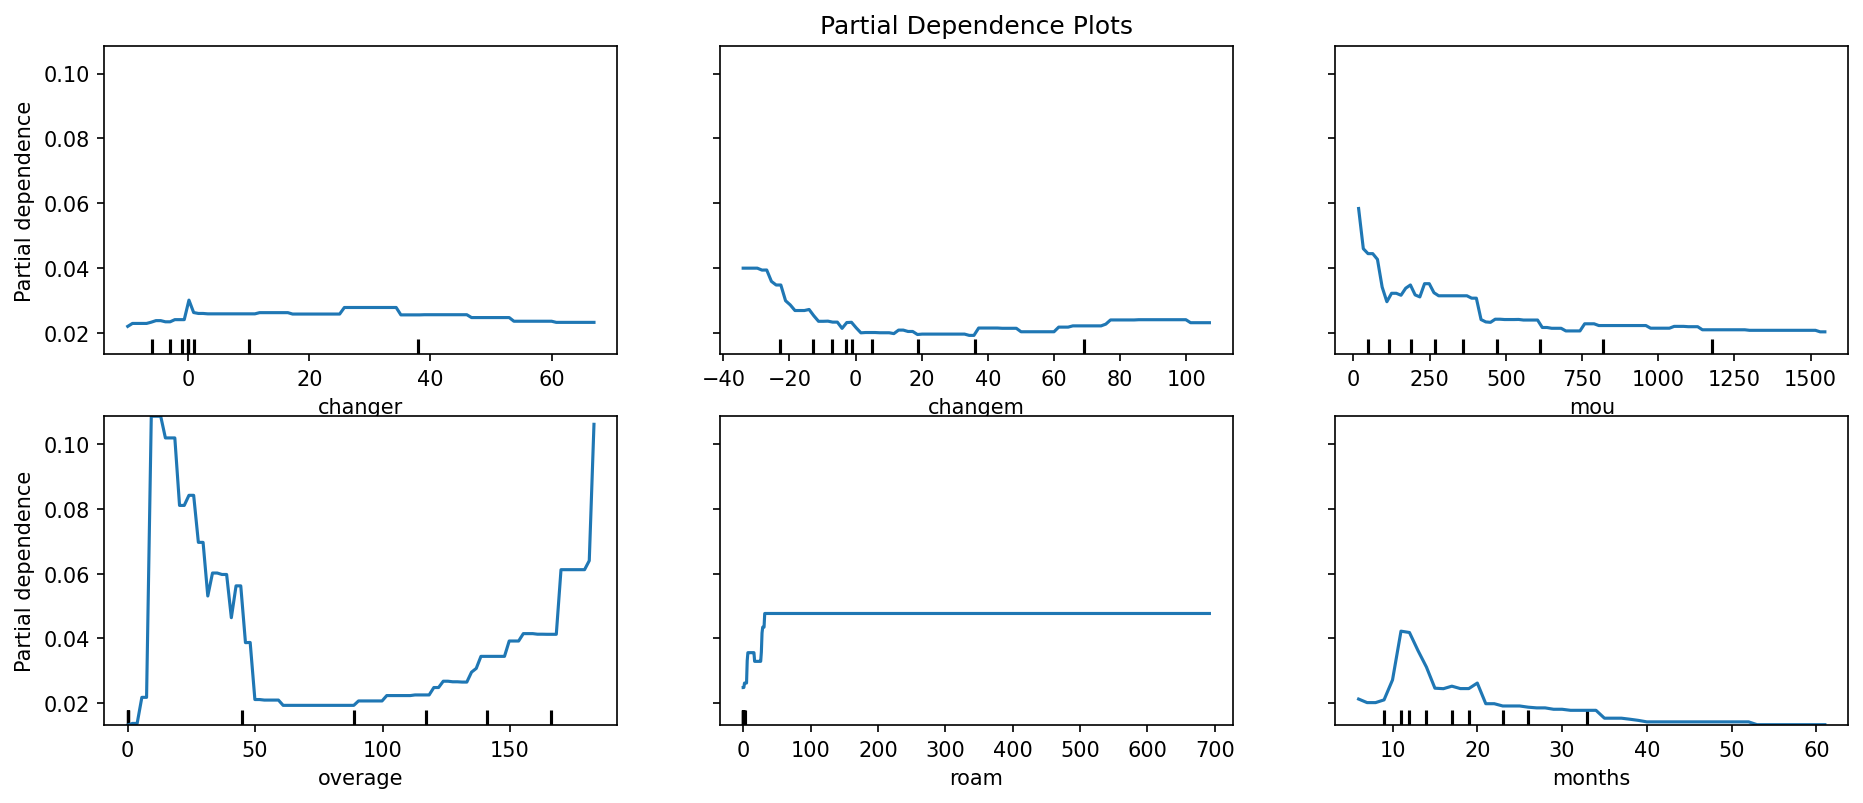

In [81]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(
    clf,
    X.iloc[X.index[s_mobile.training == 1], 0:6],
    X.columns[0:6],
    ax=ax,
)

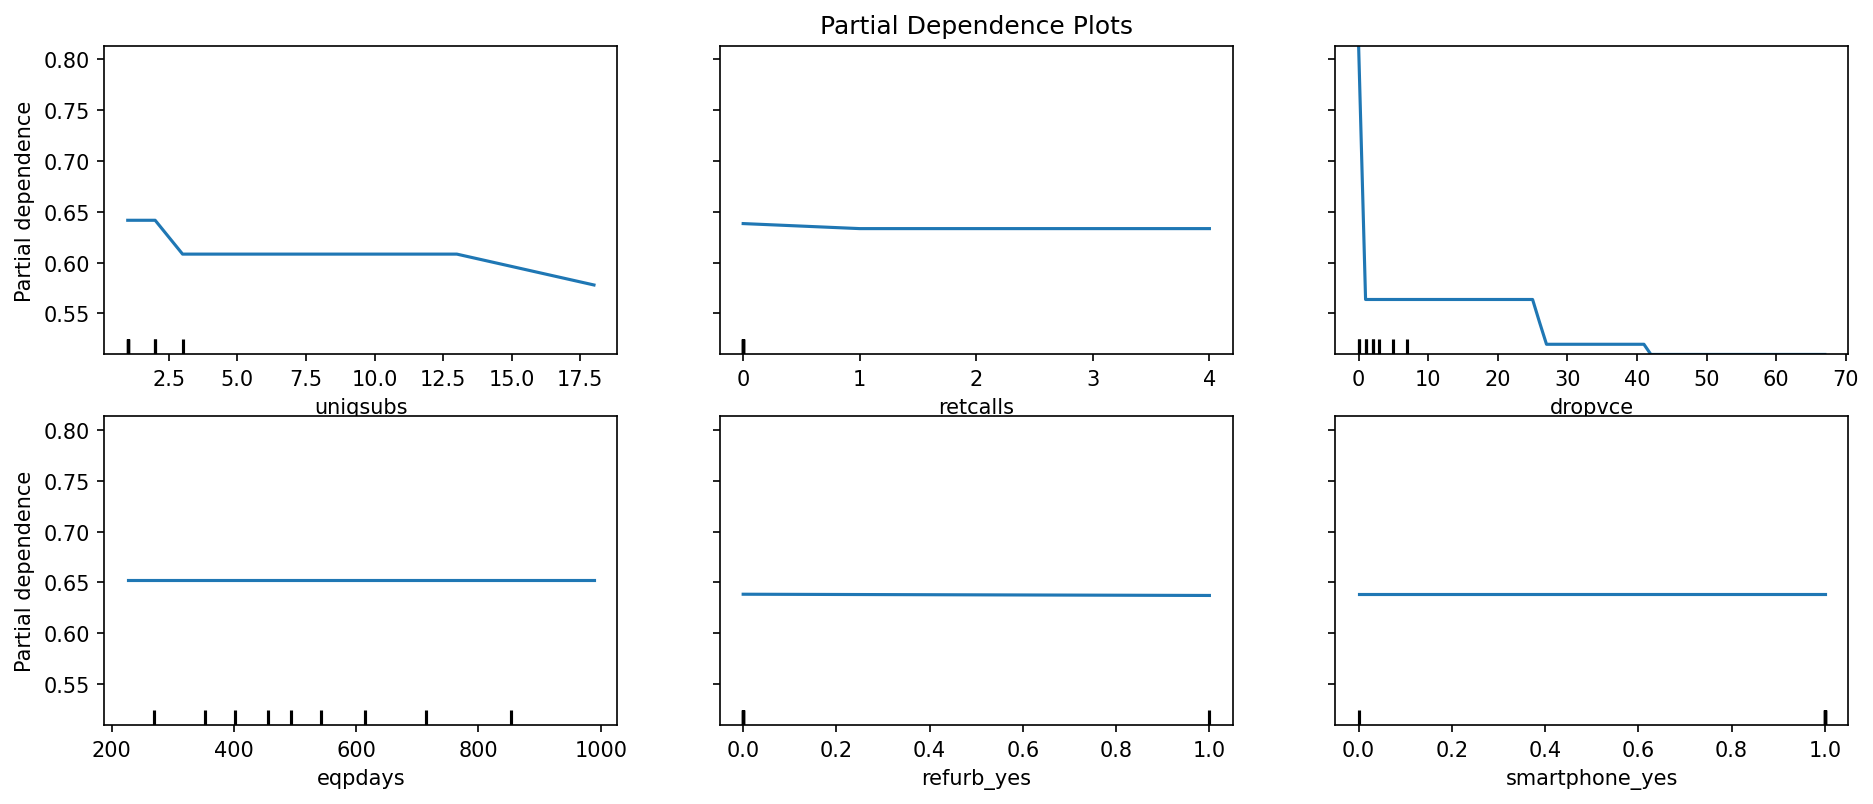

In [82]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(
    clf,
    X.iloc[X.index[s_mobile.training == 1], 6:12],
    X.columns[6:12],
    ax=ax,
)

In [85]:
from sklearn.metrics import roc_auc_score
auc1 = roc_auc_score(eval_dat[eval_dat.training == 0]['churn_yes'], eval_dat[eval_dat.training == 0]['y_lr1'])
auc2 = roc_auc_score(eval_dat[eval_dat.training == 0]['churn_yes'], eval_dat[eval_dat.training == 0]['y_lr2'])
auci = roc_auc_score(eval_dat[eval_dat.training == 0]['churn_yes'], eval_dat[eval_dat.training == 0]['y_lri'])
auc3 = roc_auc_score(eval_dat[eval_dat.training == 0]['churn_yes'], eval_dat[eval_dat.training == 0]['y_lr3'])
auc4 = roc_auc_score(eval_dat[eval_dat.training == 0]['churn_yes'], eval_dat[eval_dat.training == 0]['y_xgb'])
compare_auc = pd.DataFrame({'model':['lr1', 'lr2','lri','lr3','xgb'], 'auc':[auc1, auc2,auci, auc3, auc4]})

In [86]:
compare_auc

,model,auc
0,lr1,0.694523
1,lr2,0.694523
2,lri,0.700306
3,lr3,0.546333
4,xgb,0.754713
